In [150]:
#!pip install shap
!pip install pdpbox
#!pip install xgboost
#!pip install category_encoders
#!pip install lightgbm

  Using cached PDPbox-0.2.1-py3-none-any.whl
  Using cached matplotlib-3.1.1.tar.gz (37.8 MB)
  Running setup.py clean for matplotlib
Failed to build matplotlib
    Running setup.py install for matplotlib: started
    Running setup.py install for matplotlib: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\jhp00\anaconda3\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\jhp00\\AppData\\Local\\Temp\\pip-install-25btc7yp\\matplotlib_e7adbc4d4992473f968c3a0a5bafa558\\setup.py'"'"'; __file__='"'"'C:\\Users\\jhp00\\AppData\\Local\\Temp\\pip-install-25btc7yp\\matplotlib_e7adbc4d4992473f968c3a0a5bafa558\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\jhp00\AppData\Local\Temp\pip-wheel-fh11ngew'
       cwd: C:\Users\jhp00\AppData\Local\Temp\pip-install-25btc7yp\matplotlib_e7adbc4d4992473f968c3a0a5bafa558\
  Complete output (499 lines):
  Edit setup.cfg to change the build options
  
  BUILDING MATPLOTLIB
    matplotlib: yes [3.1.1]
      

#데이터 불러오기

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm

df = pd.read_csv('match_master.csv')
df1 = pd.read_csv('match_Diamonds2.csv')
df2 = pd.read_csv('match_grandmaster.csv')
df3 = pd.read_csv('match_Diamonds.csv')
df4 = pd.read_csv('match_Platinums.csv')
df5 = pd.read_csv('match_Diamonds34.csv')

In [3]:
df = pd.concat([df, df1])
df = pd.concat([df, df2])
df = pd.concat([df, df3])
df = pd.concat([df, df4])
df = pd.concat([df, df5])

#EDA진행

In [4]:
##ban데이터중 필요한없는 문자열 제거
df = df.drop_duplicates()
df = df.drop(df[df['bans'].str.contains('\[\]')].index)       ##ban데이터가 아예없는 행제거
df['bans'] = df['bans'].str.replace(' ','', regex=True)
df['bans'] = df['bans'].str.replace('[','', regex=True)
df['bans'] = df['bans'].str.replace(']','', regex=True)
df['bans'] = df['bans'].str.replace('{','', regex=True)
df['bans'] = df['bans'].str.replace('}','', regex=True)
df['bans'] = df['bans'].str.replace('\'championId\':','', regex=True)
df = df.reset_index(drop = True)
df['teamId'] = df['teamId'].astype(object)

In [5]:
##ban데이터 분할
ban1 = []
ban2 = []
ban3 = []
ban4 = []
ban5 = []

for i in tqdm(range(len(df['bans']))):
    for b in [0,2,4,6,8]:
        if b == 0:
            ban1.append(df['bans'][i].split(',')[b])
        elif b == 2:
            ban2.append(df['bans'][i].split(',')[b])
        elif b == 4:
            ban3.append(df['bans'][i].split(',')[b])
        elif b == 6:
            ban4.append(df['bans'][i].split(',')[b])
        elif b == 8:
            ban5.append(df['bans'][i].split(',')[b])
        
               


100%|█████████████████████████████████████████████████████████████████████████| 64506/64506 [00:01<00:00, 45198.09it/s]


In [6]:
##ban데이터 데이터프레임 생성
bans = pd.DataFrame([ban1,ban2,ban3,ban4,ban5],index = ['ban1','ban2','ban3','ban4','ban5']).T 

In [7]:
df = pd.concat([df,bans], axis = 1)   ##기존 데이터와 ban데이터 합침
df = df.drop(['bans'],axis =1)        ##기존 bans행 제거
df = df.drop(['gameId'],axis =1)      ##gameId행 제거

### 타겟데이터 불균형 확인

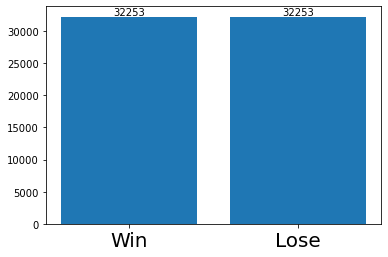

In [8]:
import matplotlib.pyplot as plt

Win = (df['win']==True).sum()
Lose = (df['win']==False).sum()

plt.bar(np.arange(2),(Win, Lose),align='center', alpha=1)
plt.xticks(np.arange(2), ('Win','Lose'),fontsize = 20)
plt.text(0,Win,Win,ha='center', va= 'bottom',fontsize = 10)
plt.text(1,Lose,Lose,ha='center', va= 'bottom',fontsize = 10);  ##데이터의 갯수 동일

### 승리팀과 패배팀의 데이터 비율 확인

In [9]:
#승자팀, 패배팀 분리
win_data = df[df['win'] == True]
lose_data = df[df['win'] == False]


#firstblood count
win_fblood = (win_data['firstBlood'] == True).value_counts()
lose_fblood = (lose_data['firstBlood'] == True).value_counts()

#firstower count
win_ftower = (win_data['firstTower'] == True).value_counts()
lose_ftower = (lose_data['firstTower'] == True).value_counts()

#firstInhibitor count
win_finhi = (win_data['firstInhibitor'] == True).value_counts()
lose_finhi = (lose_data['firstInhibitor'] == True).value_counts()

#firstBaron count
win_fbaron = (win_data['firstBaron'] == True).value_counts()
lose_fbaron = (lose_data['firstBaron'] == True).value_counts()

#firstDragon count
win_fdragon = (win_data['firstDragon'] == True).value_counts()
lose_fdragon = (lose_data['firstDragon'] == True).value_counts()

#firstRiftHerald count
win_frift = (win_data['firstRiftHerald'] == True).value_counts()
lose_frift = (lose_data['firstRiftHerald'] == True).value_counts()

data_pie = pd.DataFrame({'WinFBlood':[win_fblood[0],win_fblood[1]],
                         'LoseBlood':[lose_fblood[0],lose_fblood[1]],
    
                         'WinFtower':[win_ftower[0],win_ftower[1]],
                         'LoseFtower':[lose_ftower[0],lose_ftower[1]],

                         'WinFinhibitor':[win_finhi[0],win_finhi[1]],
                         'LoseFinhibitor':[lose_finhi[0],lose_finhi[1]],

                         'WinFbaron':[win_fbaron[0],win_fbaron[1]],
                         'LoseFbaron':[lose_fdragon[0],lose_fdragon[1]],

                         'WinFDragon':[win_fdragon[0],win_fdragon[1]],
                         'LoseFDragon':[lose_fdragon[0],lose_fdragon[1]],                         

                         'WinFRiftHerald':[win_frift[0],win_frift[1]],
                         'LoseFRiftHerald':[lose_frift[0],lose_frift[1]]
                         })

data_pie

,WinFBlood,LoseBlood,WinFtower,LoseFtower,WinFinhibitor,LoseFinhibitor,WinFbaron,LoseFbaron,WinFDragon,LoseFDragon,WinFRiftHerald,LoseFRiftHerald
0,13055,19253,8835,23615,9550,30573,14571,20694,11882,20694,12429,20262
1,19198,13000,23418,8638,22703,1680,17682,11559,20371,11559,19824,11991


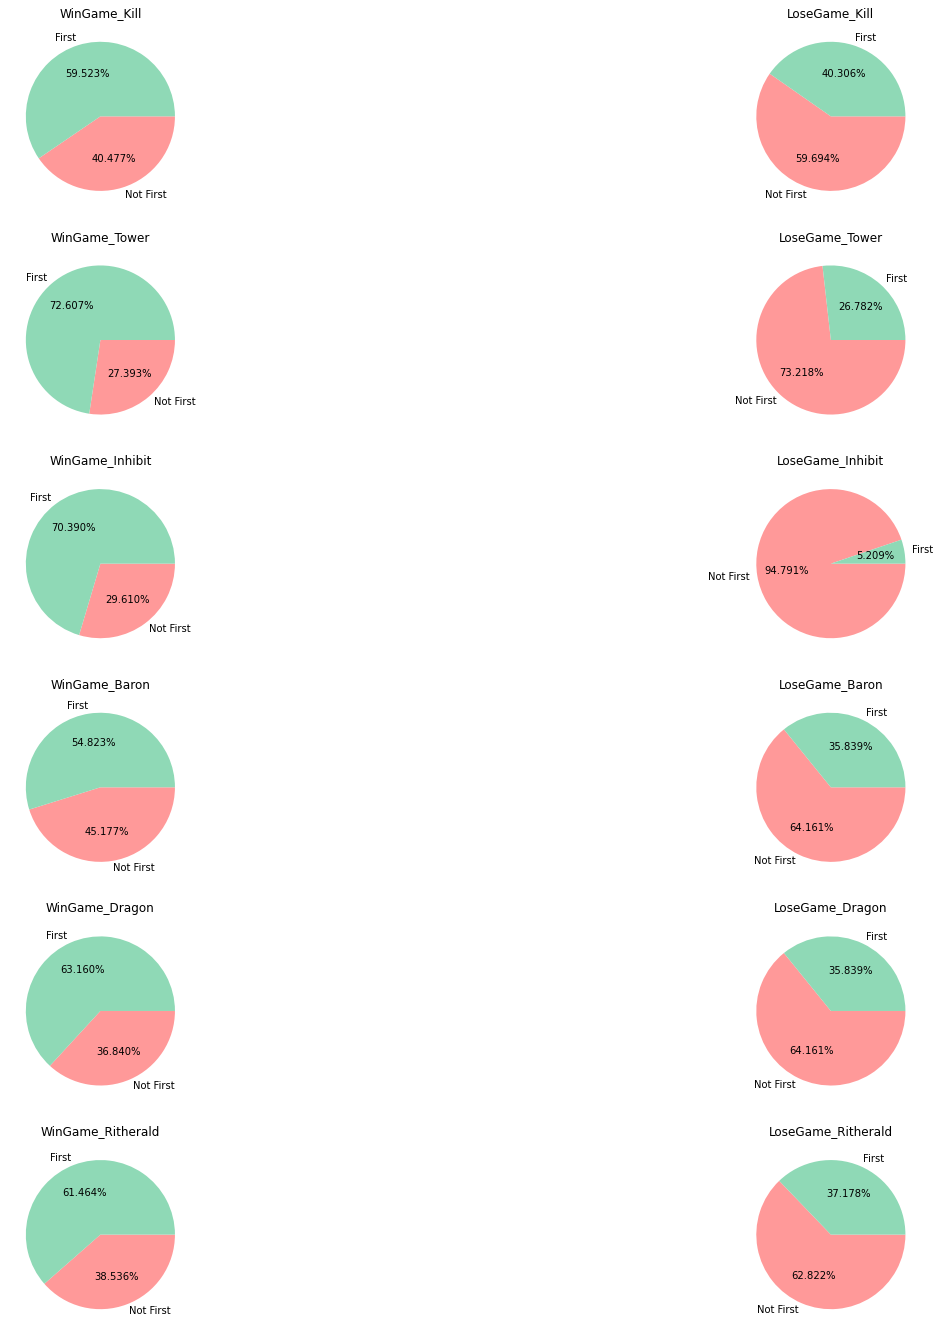

In [10]:
a = np.array(data_pie)

colors = ['#FF9999', '#8fd9b6']
fig, axes = plt.subplots(6,2,figsize=(24,24))

num = 0
for i in range(6):
    for j in range(2):
        axes[i][j].pie((a[0][num],a[1][num]),labels=['Not First','First'],autopct='%.3f%%', startangle=360, counterclock=False, colors = colors)
        num += 1

axes[0][0].set_title("WinGame_Kill")
axes[0][1].set_title("LoseGame_Kill")        
axes[1][0].set_title("WinGame_Tower")
axes[1][1].set_title("LoseGame_Tower")    
axes[2][0].set_title("WinGame_Inhibit")
axes[2][1].set_title("LoseGame_Inhibit")    
axes[3][0].set_title("WinGame_Baron")
axes[3][1].set_title("LoseGame_Baron")  
axes[4][0].set_title("WinGame_Dragon")
axes[4][1].set_title("LoseGame_Dragon")    
axes[5][0].set_title("WinGame_Ritherald")
axes[5][1].set_title("LoseGame_Ritherald")    

plt.show()

#훈련데이터, 검증데이터 분류

In [11]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold
 
train, val =  train_test_split(df, test_size=0.2, train_size= 0.8, random_state=10)

In [12]:
target = 'win'
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

#XGBoost 모델 평가

In [13]:
from category_encoders import OrdinalEncoder
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
xgb = XGBClassifier(n_jobs=-1,
                    random_state = 10)

dists = {'n_estimators' : [100,200,300,400,500,600],
        'learning_rate': [0.1, 0.2, 0.3],
        'max_depth' : [4,5,6,7]
        }

clf_xgb = GridSearchCV(
    xgb, 
    param_grid = dists,  
    cv=3, 
    scoring='f1',  
    verbose=1,
    )

clf_xgb.fit(X_train_encoded, y_train)

In [45]:
clf_xgb.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [141]:
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=7, min_child_weight=1,
              monotone_constraints='()', n_estimators=500, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

evals = [(X_val_encoded, y_val)]

xgb.fit(X_train_encoded, y_train, early_stopping_rounds=100, eval_metric="error", eval_set=evals, verbose=True)

[0]	validation_0-error:0.12440
[1]	validation_0-error:0.12277
[2]	validation_0-error:0.12277
[3]	validation_0-error:0.12083
[4]	validation_0-error:0.12114
[5]	validation_0-error:0.12006
[6]	validation_0-error:0.11913
[7]	validation_0-error:0.11828
[8]	validation_0-error:0.11758


C:\Users\jhp00\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[9]	validation_0-error:0.11727
[10]	validation_0-error:0.11742
[11]	validation_0-error:0.11688
[12]	validation_0-error:0.11742
[13]	validation_0-error:0.11680
[14]	validation_0-error:0.11611
[15]	validation_0-error:0.11626
[16]	validation_0-error:0.11618
[17]	validation_0-error:0.11618
[18]	validation_0-error:0.11665
[19]	validation_0-error:0.11665
[20]	validation_0-error:0.11611
[21]	validation_0-error:0.11580
[22]	validation_0-error:0.11626
[23]	validation_0-error:0.11665
[24]	validation_0-error:0.11649
[25]	validation_0-error:0.11649
[26]	validation_0-error:0.11665
[27]	validation_0-error:0.11595
[28]	validation_0-error:0.11603
[29]	validation_0-error:0.11572
[30]	validation_0-error:0.11587
[31]	validation_0-error:0.11487
[32]	validation_0-error:0.11518
[33]	validation_0-error:0.11502
[34]	validation_0-error:0.11518
[35]	validation_0-error:0.11541
[36]	validation_0-error:0.11611
[37]	validation_0-error:0.11626
[38]	validation_0-error:0.11680
[39]	validation_0-error:0.11580
[40]	vali

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

              precision    recall  f1-score   support

       False       0.87      0.89      0.88      6299
        True       0.90      0.88      0.89      6603

    accuracy                           0.89     12902
   macro avg       0.89      0.89      0.89     12902
weighted avg       0.89      0.89      0.89     12902

[0.8856766392807317, 0.887154770101752, 0.9571017494798524]


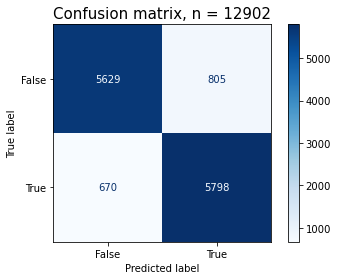

In [142]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report, plot_confusion_matrix
import matplotlib.pyplot as plt
y_pred_xgb = xgb.predict(X_val_encoded)
y_pred_xgb_proba = xgb.predict_proba(X_val_encoded)[:, -1]
print(classification_report(y_pred_xgb, y_val))

xgb_score = [accuracy_score(y_val,y_pred_xgb), f1_score(y_val, y_pred_xgb), roc_auc_score(y_val, y_pred_xgb_proba)]

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(xgb, X_val_encoded, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15);

print(xgb_score)

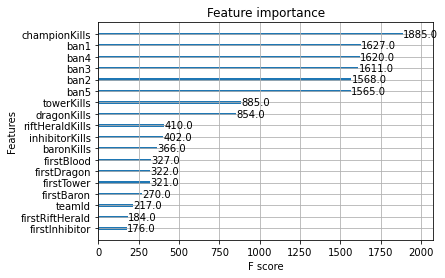

In [143]:
from xgboost import plot_importance

fig, ax = plt.subplots()
plot_importance(xgb, ax = ax);

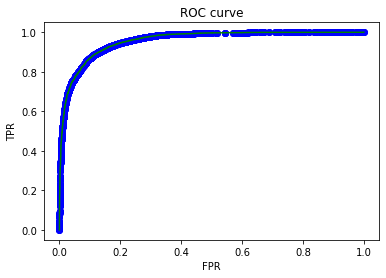

In [133]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_xgb_proba)

plt.scatter(fpr, tpr, color='blue')
plt.plot(fpr, tpr, color='green')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR');

##Random Forest 모델

In [24]:
from sklearn.ensemble import RandomForestClassifier
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
rf = RandomForestClassifier(n_estimators= 500,
                           n_jobs=-1,
                           max_depth = 7,
                           min_samples_leaf = 1,
                           random_state = 10)

rf.fit(X_train_encoded, y_train);

              precision    recall  f1-score   support

       False       0.89      0.86      0.87      6688
        True       0.85      0.88      0.87      6214

    accuracy                           0.87     12902
   macro avg       0.87      0.87      0.87     12902
weighted avg       0.87      0.87      0.87     12902

[0.8694776003720354, 0.8672133732849707, 0.9493725019891814]


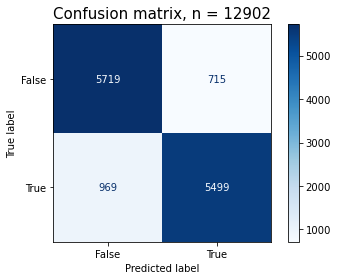

In [25]:
y_pred_rf = rf.predict(X_val_encoded)
y_pred_rf_proba = rf.predict_proba(X_val_encoded)[:, -1]
print(classification_report(y_pred_rf, y_val))

rf_score = [accuracy_score(y_val,y_pred_rf), f1_score(y_val, y_pred_rf), roc_auc_score(y_val, y_pred_rf_proba)]


fig, ax = plt.subplots()
pcm = plot_confusion_matrix(rf, X_val_encoded, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15);

print(rf_score)

##LGBOOST모델


In [138]:
from lightgbm import LGBMClassifier, plot_importance
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline


lgb = LGBMClassifier(n_jobs=-1,
                     n_estimators = 500,
                     max_depth = 7,
                     learning_rate = 0.1,                     
                     random_state = 10)
evals = [(X_val_encoded, y_val)]

lgb.fit(X_train_encoded, y_train, early_stopping_rounds=100, eval_metric="error", eval_set=evals, verbose=True)

C:\Users\jhp00\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\jhp00\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_error: 0.124477	valid_0's binary_logloss: 0.631549
[2]	valid_0's binary_error: 0.123779	valid_0's binary_logloss: 0.581154
[3]	valid_0's binary_error: 0.124322	valid_0's binary_logloss: 0.539371
[4]	valid_0's binary_error: 0.124322	valid_0's binary_logloss: 0.504132
[5]	valid_0's binary_error: 0.124322	valid_0's binary_logloss: 0.474278
[6]	valid_0's binary_error: 0.124012	valid_0's binary_logloss: 0.448651
[7]	valid_0's binary_error: 0.123237	valid_0's binary_logloss: 0.426395
[8]	valid_0's binary_error: 0.119904	valid_0's binary_logloss: 0.407271
[9]	valid_0's binary_error: 0.119749	valid_0's binary_logloss: 0.390711
[10]	valid_0's binary_error: 0.119826	valid_0's binary_logloss: 0.376424
[11]	valid_0's binary_error: 0.118974	valid_0's binary_logloss: 0.363708
[12]	valid_0's binary_error: 0.118664	valid_0's binary_logloss: 0.352656
[13]	valid_0's binary_error: 0.118741	valid_0's binary_logloss: 0.343008
[14]	valid_0's binary_error: 0.118741	valid_0's binary_loglo

LGBMClassifier(max_depth=7, n_estimators=500, random_state=10)

              precision    recall  f1-score   support

       False       0.87      0.90      0.88      6286
        True       0.90      0.88      0.89      6616

    accuracy                           0.89     12902
   macro avg       0.89      0.89      0.89     12902
weighted avg       0.89      0.89      0.89     12902



[0.8863742055495272, 0.8879547538978906, 0.9575202633120392]

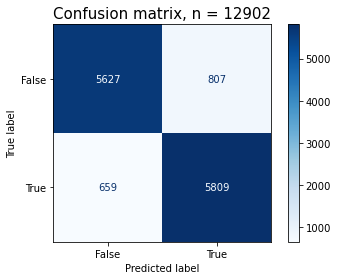

In [139]:
y_pred_lgb = lgb.predict(X_val_encoded)
y_pred_lgb_proba = lgb.predict_proba(X_val_encoded)[:, -1]
print(classification_report(y_pred_lgb, y_val))

lgb_score = [accuracy_score(y_val,y_pred_lgb), f1_score(y_val, y_pred_lgb), roc_auc_score(y_val, y_pred_lgb_proba)]


fig, ax = plt.subplots()
pcm = plot_confusion_matrix(lgb, X_val_encoded, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15);
lgb_score

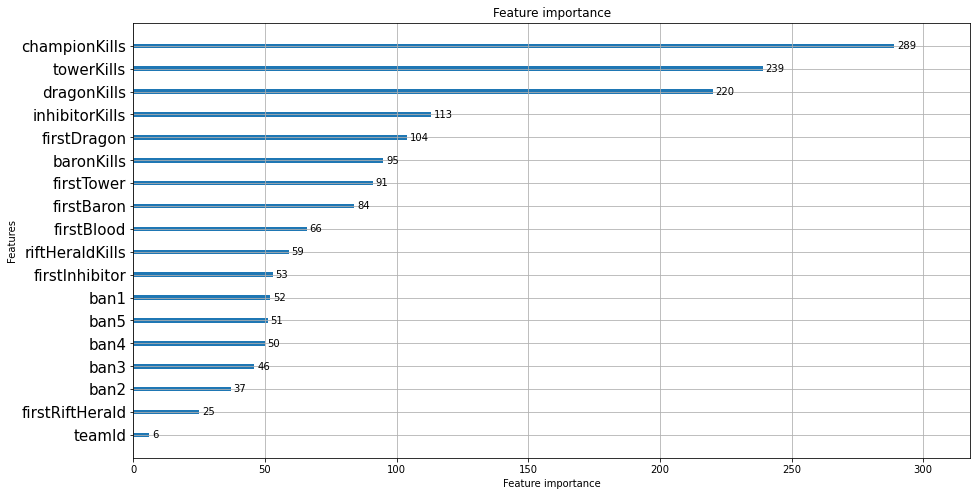

In [140]:
fig, ax = plt.subplots(figsize=(15, 8))
plot_importance(lgb, ax = ax);
plt.yticks(fontsize = 15,rotation = 0);

#모델 분석

,accuracy,f1,ACU
rf_score,0.869478,0.867213,0.949373
xgb_score,0.885677,0.887155,0.957102
lgb_score,0.886374,0.887955,0.957520


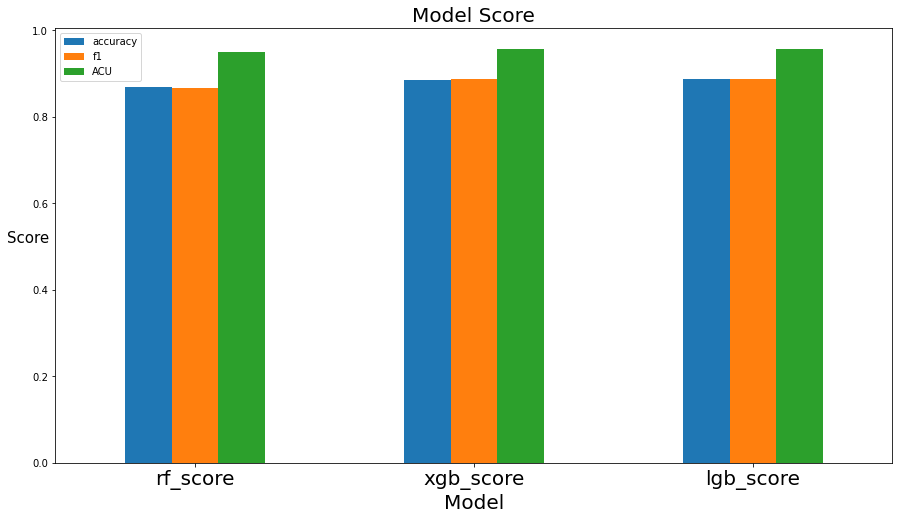

In [144]:
score = pd.DataFrame((rf_score,xgb_score,lgb_score), index = ['rf_score','xgb_score','lgb_score'], columns= ['accuracy','f1','ACU'])

score.plot(kind="bar",figsize=(15, 8))
plt.title("Model Score",fontsize = 20)
plt.xticks(fontsize = 20,rotation = 0)
plt.xlabel("Model", fontsize = 20)
plt.ylabel("Score",rotation = 0,fontsize = 15);

score

In [185]:
import shap
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot

shap.initjs();

isolated = pdp_isolate(
    model=xgb, 
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns, 
    feature='firstBaron'
)

pdp_plot(isolated, feature_name = 'firstBaron');

ModuleNotFoundError: ignored

In [ ]:
ban_win = []
ban_lose = []
ban_win = pd.concat([df[df['win'] == True]['ban1'],df[df['win'] == True]['ban2']],axis = 0)
ban_win = pd.concat([ban_win,df[df['win'] == True]['ban3']],axis = 0)
ban_win = pd.concat([ban_win,df[df['win'] == True]['ban4']],axis = 0)
ban_win = pd.concat([ban_win,df[df['win'] == True]['ban5']],axis = 0)

ban_lose = pd.concat([df[df['win'] == False]['ban1'],df[df['win'] == False]['ban2']],axis = 0)
ban_lose = pd.concat([ban_lose,df[df['win'] == False]['ban3']],axis = 0)
ban_lose = pd.concat([ban_lose,df[df['win'] == False]['ban4']],axis = 0)
ban_lose = pd.concat([ban_lose,df[df['win'] == False]['ban5']],axis = 0)

ban_lose = ban_lose.reset_index(drop=True)
ban_win = ban_win.reset_index(drop=True)

ban_lose.value_counts()

In [ ]:
ban_win.value_counts()

In [ ]:
|